# molPX intro
<pre> 
Guillermo Perez-Hernandez  guille.perez@fu-berlin.de 
</pre>
   
In this notebook we will be using the 1 millisecond trajectory of Bovine Pancreatic Trypsin Inhibitor (BPTI) generated by DE Shaw Research on the Anton Supercomputer and kindly made available by their lab. The original work is 
 
 * Shaw DE, Maragakis P, Lindorff-Larsen K, Piana S, Dror RO, Eastwood MP, Bank JA, Jumper JM, Salmon JK, Shan Y, Wriggers W: Atomic-level characterization of the structural dynamics of proteins. Science 330:341-346 (2010).  doi: 10.1126/science.1187409.
 
The trajectory has been duplicated and shortened to provide a mock-trajectory set and be able to deal with lists of trajectories of different lenghts:

 * `c-alpha_centered.stride.100.xtc`
 * `c-alpha_centered.stride.100.reversed.xtc`
 * `c-alpha_centered.stride.100.halved.xtc`

## Input types and typical usecase
The typical usecase is having molecular dynamics (MD) simulation data in form of trajectory files with extensions like `.xtc, .dcd` etc and the associated molecular topology as a `.pdb` or `.gro` file. 

These files are the most general starting point for any analysis dealing with MD, and ```molpx```'s API has been designed to be able to function without further input:

In [1]:
top = 'notebooks/data/bpti-c-alpha_centered.pdb'
MD_trajfiles = ['notebooks/data/c-alpha_centered.stride.1000.xtc',
                'notebooks/data/c-alpha_centered.stride.1000.reversed.xtc',
                'notebooks/data/c-alpha_centered.stride.1000.halved.xtc'
               ]

dt = 244 #saving interval in the .xtc files, in ns

import molpx
from matplotlib import pylab as plt
%matplotlib notebook
import pyemma
import numpy as np

# This way the user does not have to care where the data are:
top = molpx._molpxdir(top)
MD_trajfiles = [molpx._molpxdir(ff) for ff in MD_trajfiles]

**However**, `molpx` relies heavily on the awesome [`mdtraj`](http://www.mdtraj.org) module for dealing with molecular structures, and so most of `molpx`'s functions accept also `Trajectory`-type objects (native to `mdtraj`) as alternative inputs. 

In [2]:
# Create a memory representation of the trajectories
MD_list = [molpx.generate._md.load(itraj, top=top) for itraj in MD_trajfiles]

The same idea applies to the input of projected trajectories: `molpx` can take the filenames as inputs (`.npy`, `.dat`, `.txt` etc) or deal directly with `numpy.ndarray` objects. 

** These alternative, "from-memory" input modes (`md.Trajectory` and `np.ndarray` objects) avoid forcing the user to read from file everytime an API function is called, saving `I/O` overhead**

The following cell either reads or generates projected trajectory files for this demonstration. In a real usecase this step (done here using TICA) might not be needed, given that the user might have generated the projected trajectory elsewhere:

In [3]:
# Perform TICA or read from file directly if already .npy-files already exist
Y_filenames = [ff.replace('.xtc','.Y.npy') for ff in MD_trajfiles]
try:        
    Y = [np.load(ff) for ff in Y_filenames]
except:
    import pyemma
    feat = pyemma.coordinates.featurizer(top)
    pairs = feat.pairs(range(feat.topology.n_atoms)[::2])
    feat.add_distances(pairs)
    src  = pyemma.coordinates.source(MD_trajfiles, features=feat)
    tica = pyemma.coordinates.tica(src, lag=10, dim=3)
    Y = tica.get_output()        
    [np.save(ff, iY) for ff, iY in zip(Y_filenames, Y)]

## Visualize a FES and the molecular structures behind it
Execute the following cell and click either on the FES or on the slidebar. Some input parameters have been comented out for you to try out different modes of input (disk vs memory) as well as different projection indices:

<IPython.core.display.Javascript object>


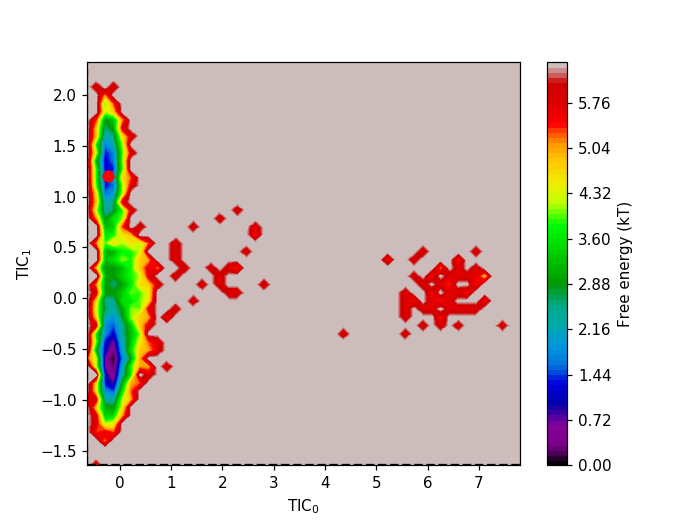

/home/mi/gph82/miniconda3/lib/python3.4/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [4]:
ax, fig, iwd, data_sample, geom = molpx.visualize.FES(
                                                      MD_list, 
                                                      #MD_trajfiles, 
                                                      top, 
                                                      Y_filenames, 
                                                      #Y, 
                                                      nbins=50, 
                                                      #proj_idxs=[1,2],
                                                      axlabel='TIC',
                                          )
iwd

## Visualize trajectories, FES and molecular structures
The user can sample structures as they occurr in sequence in the actual trajectory. Depending on the size of the dataset, this can be very time consuming, particularly if data is being read from disk. 

In this example, try changing `MD_trajfiles` to `MD_list` and/or changing `Y_filenames` to simply `Y` and see if it helps.

Furthermore, the objects in memory can be strided down to fewer frames **before** being parsed to the method. To stride objects being read from the dist, use the `stride` parameter. 

Other commented parameters provide more control on the output of `visualize.traj`. Uncomment them and see what happens

<IPython.core.display.Javascript object>


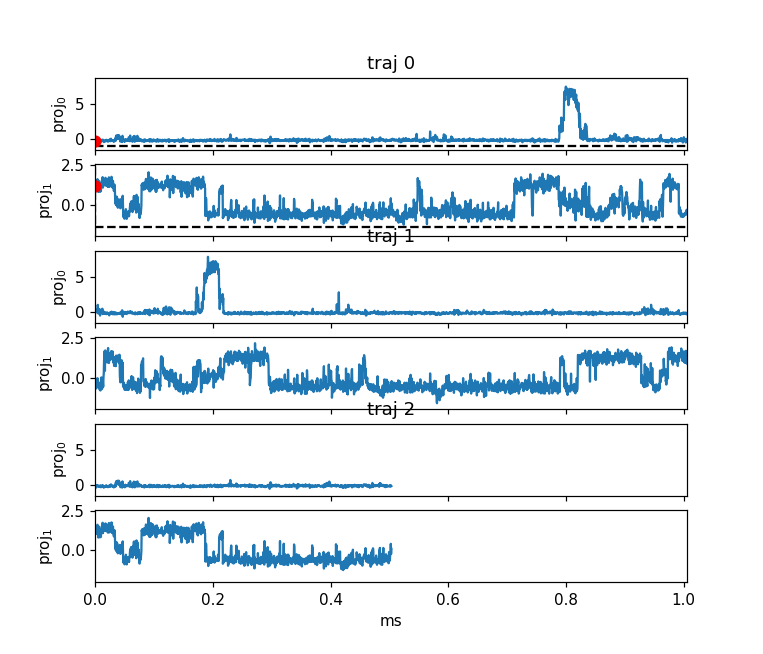

<IPython.core.display.Javascript object>


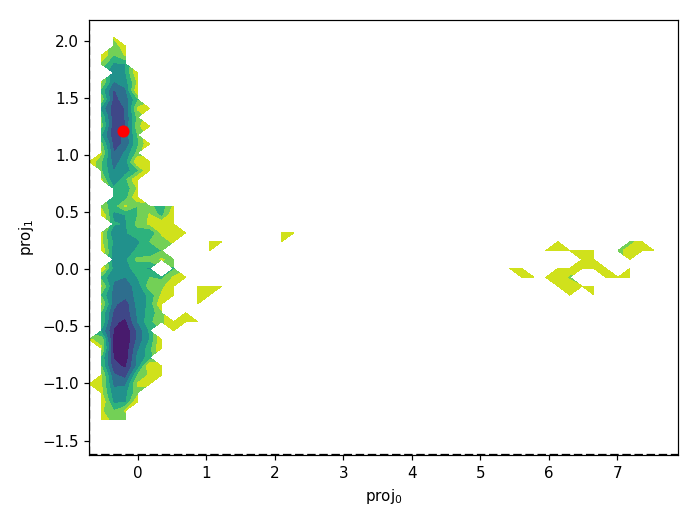

/home/mi/gph82/SOURCE_gph82/python/molPX/molpx/visualize.py:255: RuntimeWarning: divide by zero encountered in log
  _plt.contourf(-_np.log(h).T, extent=irange)


In [5]:
proj_stride=5
__, myfig, iwd, __ = molpx.visualize.traj(MD_trajfiles,     
                                          top,                                                                                                                              
                                          Y_filenames,                                          
                                          plot_FES = True,                                        
                                          dt = dt*1e-6, tunits='ms',                                           
                                          #active_traj=2,
                                          #traj_selection = [0, 2],
                                          #max_frames=100,
                                          #proj_idxs=[0,2],  
                          )
myfig.tight_layout()
iwd

# Intermediate steps: using molpx to generate a regspace sample of the data
See the documentation of `molpx.generate.sample` to find out about all possible options:
```
molpx.generate.sample(MD_trajectories, MD_top, projected_trajectories, proj_idxs=[0, 1], n_points=100, n_geom_samples=1, keep_all_samples=False, proj_stride=1, verbose=False, return_data=False)
```

In [6]:
data_sample, geoms = molpx.generate.sample(#MD_list, 
                                           MD_trajfiles, 
                                           top, 
                                           #Y, 
                                           Y_filenames,
                                           n_points=200                                      
                                    )
data_sample.shape, geoms


((192, 2),
 <mdtraj.Trajectory with 192 frames, 58 atoms, 58 residues, and unitcells at 0x7ff86f5a4da0>)

## Link the PDF plot with the sampled structures and visually explore the FES 
Click either on the plot or on the widget slidebar: they're connected! 

<IPython.core.display.Javascript object>


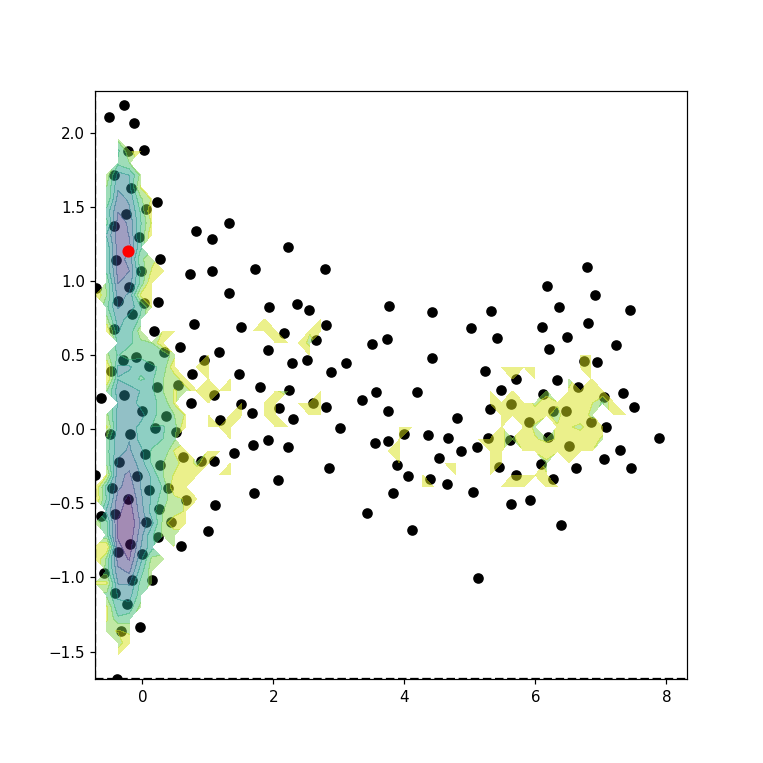

/home/mi/gph82/miniconda3/lib/python3.4/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


In [7]:
# Replot the FES
plt.figure(figsize=(7,7))
h, (x,y) = np.histogramdd(np.vstack(Y)[:,:2], bins=50)
plt.contourf(x[:-1], y[:-1], -np.log(h.T), alpha=.50)
# Create the linked widget
linked_wdg = molpx.visualize.sample(data_sample, 
                              geoms.superpose(geoms[0]),                             
                              plt.gca(), 
                              clear_lines=True,
                              #plot_path=True
                            )
plt.plot(data_sample[:,0], data_sample[:,1],' ok', zorder=0)
# Show it
linked_wdg


# Paths samples along the different projections (=axis)

In [8]:
paths_dict, idata = molpx.generate.projection_paths(#MD_list, 
                                                    MD_trajfiles, 
                                                    top, 
                                                    Y_filenames,
                                                    #Y, # You can also directly give the data here
                                                    n_points=50,
                                                    proj_idxs=[0,1],
                                                    n_projs=3,
                                                    proj_dim = 3, 
                                                    verbose=False, 
                                        )

## Link the PDF plot with the sampled paths/structures and visually explore the coordinates (separately). 
Click either on the plot or on the widget slidebar: they're connected! You can change the type of path between min_rmsd or min_disp and you can also change the coordinate sampled (0 or 1)


In [9]:
# Choose the coordinate and the tyep of path
coord = 1
#path_type = 'min_rmsd'
path_type = 'min_disp'
igeom = paths_dict[coord][path_type]["geom"]
ipath = paths_dict[coord][path_type]["proj"]

# Choose the proj_idxs for the path and the FES 
# to be shown
proj_idxs = [0,1]

<IPython.core.display.Javascript object>


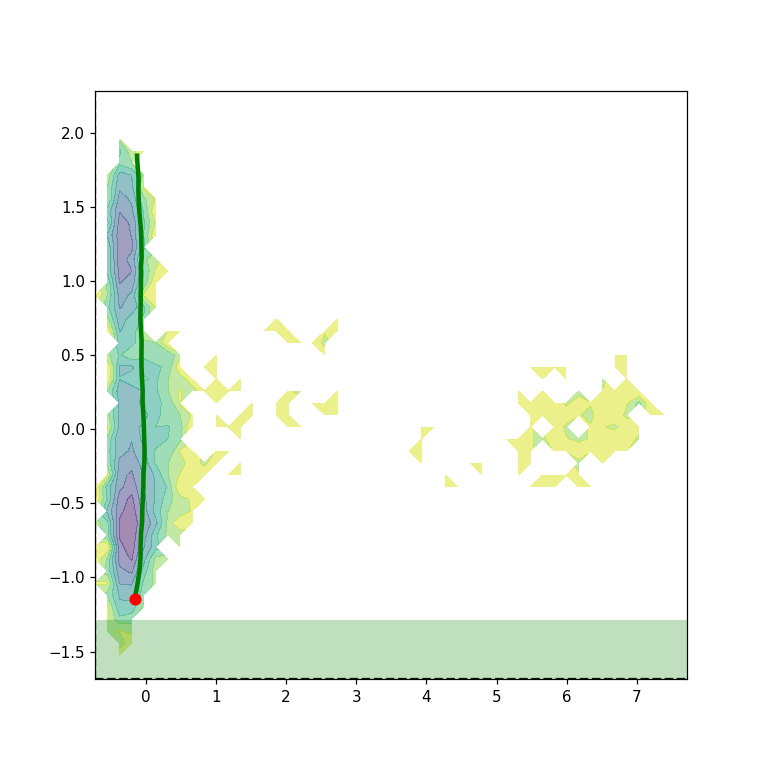

/home/mi/gph82/miniconda3/lib/python3.4/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


In [10]:
plt.figure(figsize=(7,7))
h, (x,y) = np.histogramdd(np.vstack(Y)[:,proj_idxs], bins=50)
plt.contourf(x[:-1], y[:-1], -np.log(h.T), alpha=.50)

linked_wdg = molpx.visualize.sample(ipath[:,proj_idxs], 
                                    igeom.superpose(igeom[0]),                             
                                    plt.gca(), 
                                    clear_lines=True,
                                    n_smooth = 5, 
                                    plot_path=True,                        
                                    #radius=True,
                            )
linked_wdg

# Interaction with ```PyEMMA```
`molpx` is using many methods of the `coordinates` submodule of `PyEMMA`, and thus it also understands some of `PyEMMA`'s classes as input (for the moment, only clustering).

## Use a clustering object as input 
If the dataset has already been clustered, and it is **that** clustering that the user wants to explore, `molpx.generate.sample` can take this clustering object as an input instead of the 
the projected trajectories:

In [11]:
# Do "some" clustering
clkmeans = pyemma.coordinates.cluster_kmeans([iY[:,:2] for iY in Y], 5)

08-03-17 17:03:25 pyemma.coordinates.clustering.kmeans.KmeansClustering[4] INFO     Cluster centers converged after 6 steps.


In [12]:
data_sample, geoms = molpx.generate.sample(MD_trajfiles, top, clkmeans, 
                                     n_geom_samples=50, 
                                     #keep_all_samples=True # read the doc for this argument
                                    )

<IPython.core.display.Javascript object>


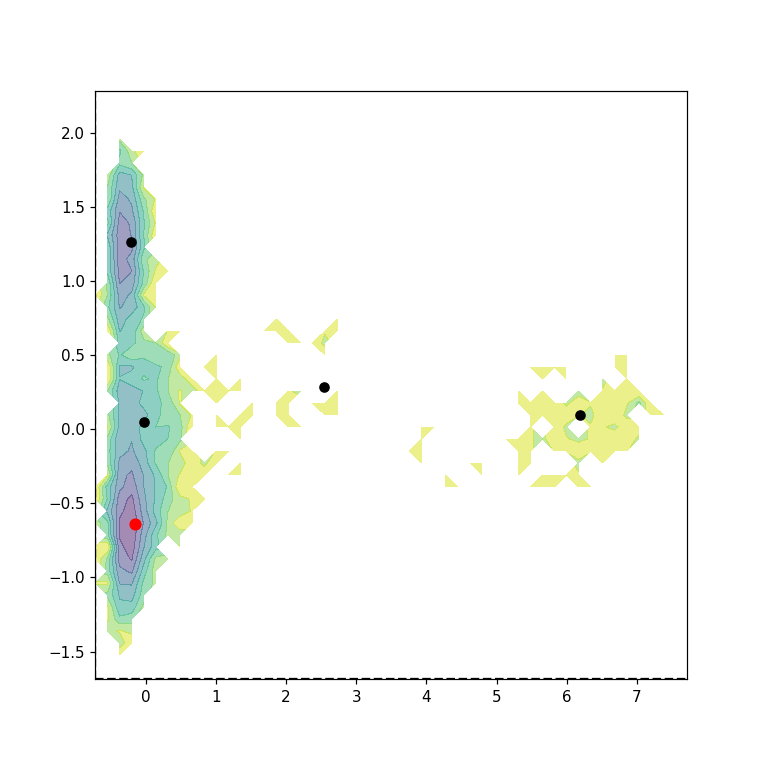

/home/mi/gph82/miniconda3/lib/python3.4/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log


In [13]:
# Plot clusters
plt.figure(figsize=(7,7))
plt.plot(clkmeans.clustercenters[:,0], clkmeans.clustercenters[:,1],' ok')
# FES as background is optional (change the bool to False)
if True:
    plt.contourf(x[:-1], y[:-1], -np.log(h.T), alpha=.50)

# Link the clusters positions with the molecular structures
iwdg = molpx.visualize.sample(data_sample, 
                              geoms.superpose(geoms[0]),                             
                              plt.gca(), 
                              clear_lines=False,
                              #plot_path=True
                            )
iwdg

## Visual representations for MSMs
Visually inspect the network behind an MSM

In [14]:
MSM = pyemma.msm.estimate_markov_model(clkmeans.dtrajs, 20)

<IPython.core.display.Javascript object>


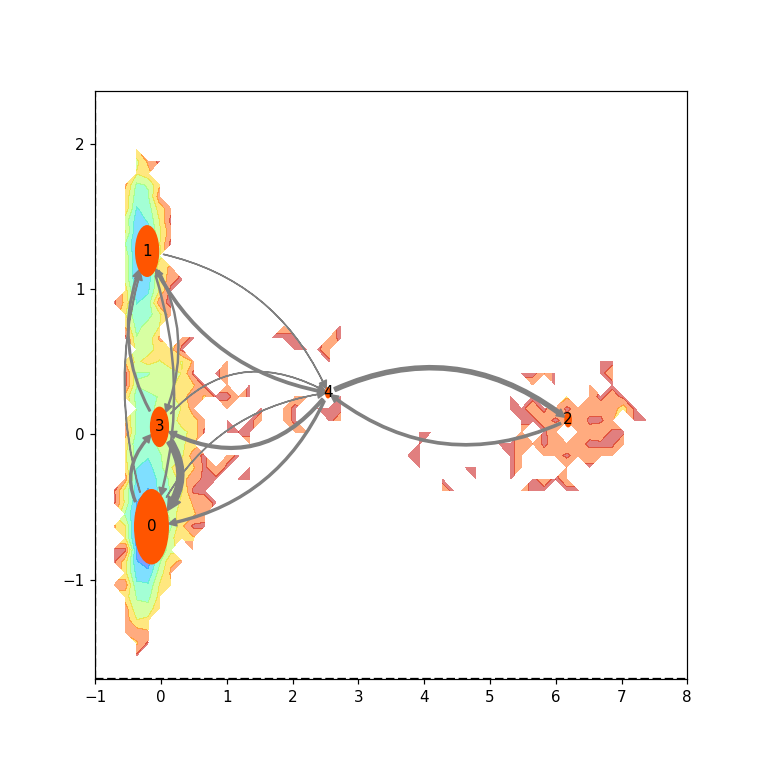

/home/mi/gph82/miniconda3/lib/python3.4/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log


In [15]:
plt.figure(figsize=(7,7))

ax, pos  = pyemma.plots.plot_markov_model(MSM.P, 
                                          minflux=5e-4, 
                                          arrow_labels=None,
                                          ax=plt.gca(), 
                                          arrow_curvature = 2, show_frame=True,
                                          pos=clkmeans.clustercenters)
# Add a background if wanted
h, (x, y) = np.histogramdd(np.vstack(Y)[:,:2], weights=np.hstack(MSM.trajectory_weights()),  bins=50)
plt.contourf(x[:-1], y[:-1], -np.log(h.T), cmap="jet", alpha=.5, zorder=0)
plt.xlim(x[[0,-1]])
plt.xticks(np.unique(x.round()))
plt.yticks(np.unique(y.round()))

plt.ylim(y[[0,-1]])

iwd = molpx.visualize.sample(pos, geoms, plt.gca())
iwd

## TPT Reactive Pathway Representation

In [16]:
# Do an MSM with a realistic number of clustercenters
cl_many = pyemma.coordinates.cluster_regspace([iY[:,:2] for iY in Y], dmin=.25)
M = pyemma.msm.estimate_markov_model(cl_many.dtrajs, 20)
cl_many.n_clusters

123

In [17]:
# Use this object to sample geometries
pos, geom = molpx.generate.sample(MD_trajfiles, top, cl_many)

In [18]:
# Find the most representative microstate of each 
# and least populated macrostate
M.pcca(3)
dens_max_i = [distro.argmax() for distro in M.metastable_distributions]
A = np.argmax([M.stationary_distribution[iset].sum() for iset in M.metastable_sets])
B = np.argmin([M.stationary_distribution[iset].sum() for iset in M.metastable_sets])
print(cl_many.clustercenters[dens_max_i[A]],
      cl_many.clustercenters[dens_max_i[B]])

[-0.18704125 -0.77366424] [ 6.71851349  0.03159955]


In [19]:
# Create a TPT object with most_pop, least_pop as source, sink respectively
tpt = pyemma.msm.tpt(M, [dens_max_i[A]], [dens_max_i[B]])
paths, flux = tpt.pathways(fraction=.5)

In [20]:
# Get a path with a decent number of intermediates
sample_path = paths[np.argmax([len(ipath) for ipath in paths])]

<IPython.core.display.Javascript object>


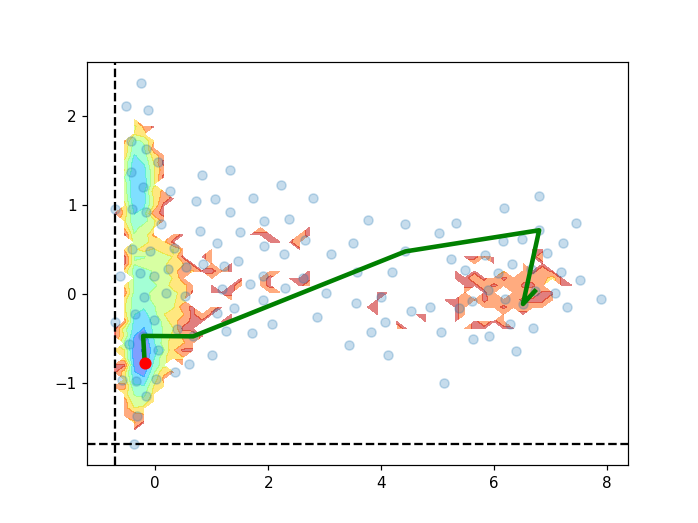

/home/mi/gph82/miniconda3/lib/python3.4/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


In [21]:
plt.figure()
plt.contourf(x[:-1], y[:-1], -np.log(h.T), cmap="jet", alpha=.5, zorder=0)
iwd = molpx.visualize.sample(cl_many.clustercenters[sample_path], 
                       geom[sample_path].superpose(geom[sample_path[0]]), plt.gca(), 
                       plot_path=True,
                      )
plt.scatter(*cl_many.clustercenters.T, alpha=.25)
iwd

In [22]:
# Check
# https://github.com/arose/nglview/issues/518
# https://github.com/arose/nglview/issues/517